In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import xgboost as xgb

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
sns.set_style('white')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train['sentence_length_chars'] = train.text.apply(len)
test['sentence_length_chars'] = test.text.apply(len)

train['text_stripped'] = train.text.str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))
test['text_stripped'] = test.text.str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))

train['words'] = train.text_stripped.str.split()
test['words'] = test.text_stripped.str.split()

train['sentence_length_words'] = train.words.apply(len)
test['sentence_length_words'] = test.words.apply(len)

train['mean_word_length'] = train.sentence_length_chars/train.sentence_length_words
test['mean_word_length'] = test.sentence_length_chars/test.sentence_length_words

train['comma_count'] = train.text.str.count(',')
test['comma_count'] = test.text.str.count(',')

train['comma_density'] = train.comma_count/train.sentence_length_chars
test['comma_density'] = test.comma_count/test.sentence_length_chars

train['quote_count'] = train.text.str.count('"')
test['quote_count'] = test.text.str.count('"')

train['quote_density'] = train.quote_count/train.sentence_length_chars
test['quote_density'] = test.quote_count/test.sentence_length_chars

train['apos_count'] = train.text.str.count("'")
test['apos_count'] = test.text.str.count("'")

train['apos_density'] = train.apos_count/train.sentence_length_chars
test['apos_density'] = test.apos_count/test.sentence_length_chars

train['first_word'] = train.words.apply(lambda x: x[0])
test['first_word'] = test.words.apply(lambda x: x[0])

train['last_word'] = train.words.apply(lambda x: x[-1])
test['last_word'] = test.words.apply(lambda x: x[-1])

In [5]:
eap, hpl, mws = (
    train[train.author=='EAP'].text_stripped, 
    train[train.author=='HPL'].text_stripped, 
    train[train.author=='MWS'].text_stripped
)

vec = CountVectorizer(ngram_range=(2, 5), min_df=15, stop_words='english')
corpus = vec.fit_transform(train.text_stripped)
vocab = vec.vocabulary_
        
eap, hpl, mws = vec.transform(eap), vec.transform(hpl), vec.transform(mws)

In [6]:
total_freq = corpus.todense().sum(axis=0)
eap_freq = eap.todense().sum(axis=0)/total_freq
hpl_freq = hpl.todense().sum(axis=0)/total_freq
eap_freq = mws.todense().sum(axis=0)/total_freq

In [7]:
freqs_max = np.array([eap_freq, hpl_freq, eap_freq]).max(axis=0)
freqs_min = np.array([eap_freq, hpl_freq, eap_freq]).min(axis=0)

In [8]:
def get_best_grams(train, min_freq=50, freqs_min=.28, freqs_max=.42):
    eap, hpl, mws = (
        train[train.author=='EAP'].text_stripped, 
        train[train.author=='HPL'].text_stripped, 
        train[train.author=='MWS'].text_stripped
    )

    vec = CountVectorizer(ngram_range=(1, 5), min_df=min_freq, stop_words='english')
    corpus = vec.fit_transform(train.text_stripped)
    vocab = vec.vocabulary_

    eap, hpl, mws = vec.transform(eap), vec.transform(hpl), vec.transform(mws)

    total_freq = corpus.todense().sum(axis=0)
    eap_freq = eap.todense().sum(axis=0)/total_freq
    hpl_freq = hpl.todense().sum(axis=0)/total_freq
    eap_freq = mws.todense().sum(axis=0)/total_freq

    freqs_max = np.array([eap_freq, hpl_freq, eap_freq]).max(axis=0)
    freqs_min = np.array([eap_freq, hpl_freq, eap_freq]).min(axis=0)

    top_tier = np.where(freqs_max >= freqs_max, 1, 0)
    bottom_tier = np.where(freqs_min <= freqs_min, 1, 0)
    tot = np.where((top_tier + bottom_tier) > 0, 1, 0)
    vocab_frame = pd.DataFrame()
    vocab_frame['items'] = vocab.items()
    vocab_frame['gram'] = vocab_frame['items'].apply(lambda x: x[0])
    vocab_frame.index = vocab_frame['items'].apply(lambda x: x[1])

    indcs = []
    for i, val in enumerate(tot[0]):
        if val > 0:
            indcs.append(i)
    
    return list(vocab_frame.loc[indcs].gram)


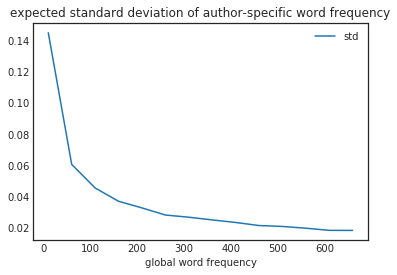

In [9]:
def get_freqs(total_freq=5, samples=100):
    freqs = []
    turn = 0
    while turn < samples:
        turn += 1
        n = total_freq
        val = np.random.random(n)
        freqs.append(np.where(val > 2/3, 1, 0).sum()/n)
        freqs.append(np.where((val > 1/3) & (val <=2/3), 1, 0).sum()/n)
        freqs.append(np.where(val <= 1/3, 1, 0).sum()/n)
    return freqs

ns = []
stds = []
means = []
for n in range(10, 700, 50):
    ns.append(n)
    stds.append(pd.Series(get_freqs(total_freq=n, samples=1000)).std())
    
plt.plot(ns, stds, label='std');
plt.title('expected standard deviation of author-specific word frequency')
plt.xlabel('global word frequency')

plt.legend();
plt.show()

result = pd.DataFrame()
result['global_frequency'] = ns
result['expected_standard_deviation'] = stds

result['lower_threshold'] = (1/3) - (2/3 * result.expected_standard_deviation)
result['upper_threshold'] = (1/3) + (4/3 * result.expected_standard_deviation)

In [10]:
best_grams = []
for ind in result.index:
    row = result.loc[ind]
    if ind%5==0:
        print('completed {} of {} tasks.'.format(ind, len(result)))
    best_grams += get_best_grams(train, min_freq=int(row.global_frequency), freqs_min=row.lower_threshold, freqs_max=row.upper_threshold)
    
best_grams = set(best_grams)

completed 0 of 14 tasks.
completed 5 of 14 tasks.
completed 10 of 14 tasks.


In [11]:
best_vec = CountVectorizer(vocabulary = best_grams)
best_vec.fit(list())

best_fts = best_vec.transform(train.text_stripped)

In [12]:
best_grams

{'hoped',
 'ellison',
 'perform',
 'grim',
 'relation',
 'discovered',
 'turned eyes',
 'twisted',
 'proceedings',
 'account',
 'loudly',
 'services',
 'suggestion',
 'season',
 'receiving',
 'reluctance',
 'capacity',
 'dismissed',
 'edinburgh',
 'exposed',
 'finding',
 'lying',
 'curtains',
 'flow',
 'diary',
 'considerable',
 'em',
 'alteration',
 'du',
 'jest',
 'pass',
 'precaution',
 'recorded',
 'wise',
 'glad',
 'assuredly',
 'usher',
 'unnamable',
 'kind',
 'hastened',
 'monster',
 'burst',
 'poured',
 'recent',
 'beauty',
 'stop',
 'desired',
 'promises',
 'conceive',
 'masses',
 'easily',
 'nerve',
 'fools',
 'shocking',
 'martense',
 'grieved',
 'child',
 'gaze',
 'dinner',
 'thoughts',
 'hills',
 'frightful',
 'lighter',
 'remark',
 'acts',
 'relieved',
 'looks',
 'task',
 'corresponding',
 'shore',
 'topic',
 'weakness',
 'preferred',
 'crushed',
 'lightning',
 'burden',
 'relative',
 'geneva',
 'theatre',
 'worn',
 'presently',
 'attracted',
 'festival',
 'awaked',
 'cre

In [13]:
total_freq = corpus.todense().sum(axis=0)
eap_freq = eap.todense().sum(axis=0)/total_freq
hpl_freq = hpl.todense().sum(axis=0)/total_freq
eap_freq = mws.todense().sum(axis=0)/total_freq

In [14]:
#tv = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
#tv.fit(train.text)
#text_fts = tv.transform(train.text)

In [15]:
#text_fts

In [16]:
fts = [
    'sentence_length_chars',
    'mean_word_length',
    'comma_count',
    'comma_density',
    'quote_density',
    'apos_density',
    'apos_count',
    'quote_count'
]

fws = pd.get_dummies(train.first_word)
fws.columns = np.where(True, fws.columns + '_first', None)
#lws = pd.get_dummies(train.last_word)
#lws.columns = np.where(True, lws.columns + '_last', None)

#X = scipy.sparse.hstack((train[fts], fws, best_fts))
X = scipy.sparse.hstack((pd.concat([train[fts], fws], axis=1), best_fts))
#X = pd.concat([train[fts], gw_fts, fws], axis=1)
Y = train.author

In [17]:
#X

In [18]:
#dtrain = xgb.DMatrix(X, label=Y)


In [ ]:
#mod = xgb.XGBClassifier(nthread=4)

#mod.fit(X, Y)
#cross_val_score(mod, X, Y, cv=3)

In [ ]:
rfc = RandomForestClassifier(n_estimators=100)
#mod.fit(X, Y)
cross_val_score(rfc, X, Y, cv=3)